## A0 - Basic analysis for PASTA outputs

This notebook demonstrates how to perform basic analyses on PASTA outputs, including visualization, statistical analysis, positive region calculation, and basic spatial transcriptomics analysis.

In [ ]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from typing import List, Dict

### Read npz file

In [ ]:
pred_npz = np.load('/workspace/results/demo/predictions/demo.ome/CAF_downsample_10.npz')['data']

In [ ]:
masked_pred = np.ma.masked_equal(pred_npz, 0)  

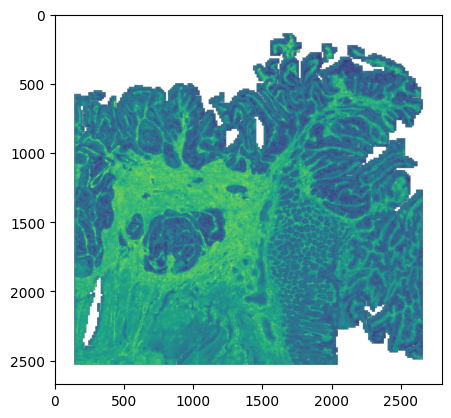

In [ ]:
plt.imshow(masked_pred)

In [ ]:
def describe(image_tensor, thr=1, return_norm=False, hist_img=True):
    max_ = image_tensor.max()
    min_ = image_tensor.min()
    median_ = np.median(image_tensor)
    print(f'Max:{max_:.3f}, Min:{min_:.3f}, Median:{median_:.3f}')
    
    if hist_img:
        plt.figure(figsize=(6,4))
        plt.hist(image_tensor.flatten(), bins=100, color='steelblue', alpha=0.8)
        plt.show()
    
    if return_norm:
        image_tensor_norm = (image_tensor - np.min(image_tensor)) / (np.max(image_tensor) - np.min(image_tensor))
        return image_tensor_norm
    else:
        return None
    

Max:2.811, Min:-2.711, Median:-0.236


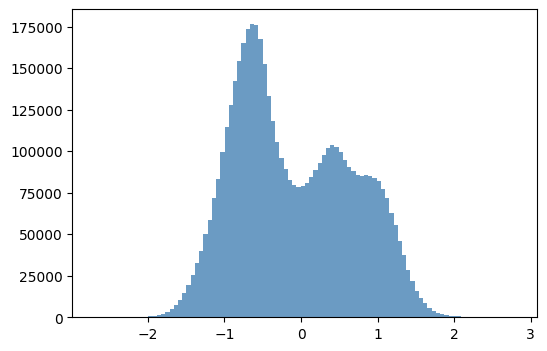

In [ ]:
describe(masked_pred.compressed())

### Read h5ad file

The high resolution results(pixel level) and low resolution results(spot level) can be treated in the same way.

In [ ]:
adata = sc.read_h5ad('/workspace/results/demo/predictions/demo.ome.h5ad')

B-cells
Max:1.479, Min:-1.950, Median:-0.223


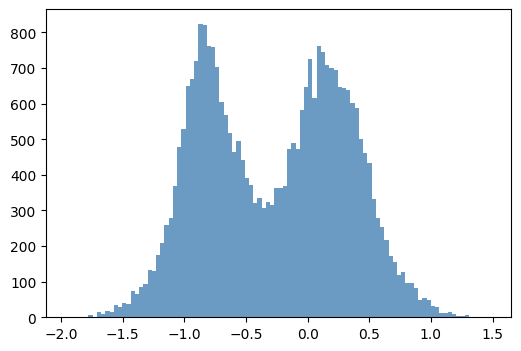

CAF
Max:1.581, Min:-1.724, Median:-0.174


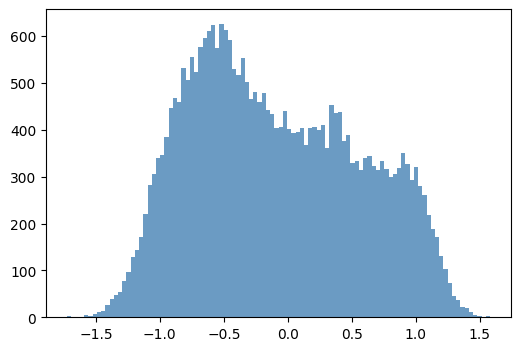

Cell-Cycle
Max:2.857, Min:-1.192, Median:0.189


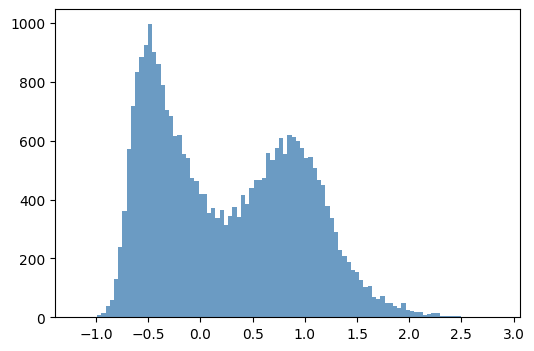

DC
Max:1.894, Min:-1.667, Median:-0.165


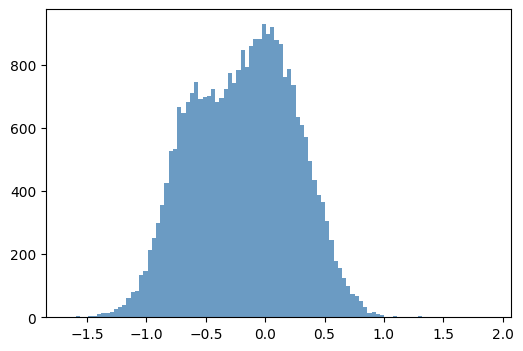

EMT
Max:1.699, Min:-1.949, Median:0.319


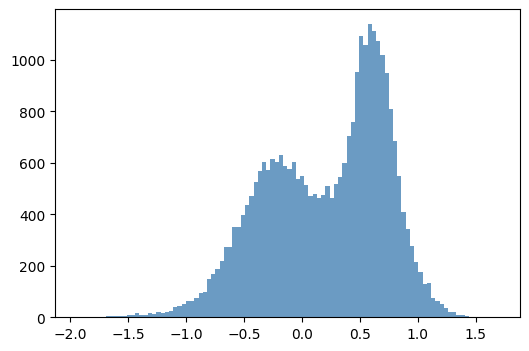

Endothelium
Max:2.305, Min:-1.611, Median:-0.246


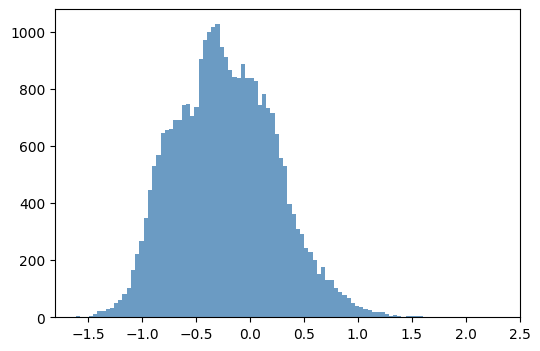

Hypoxia
Max:1.564, Min:-1.695, Median:0.249


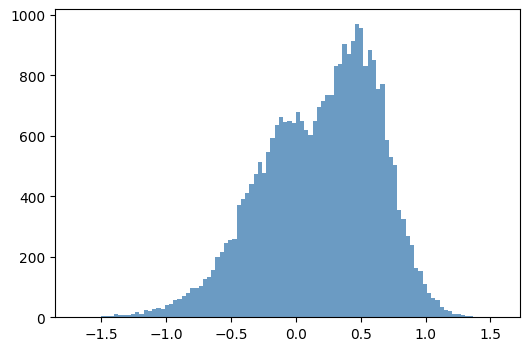

Interferon-MHC-II
Max:1.405, Min:-1.837, Median:-0.022


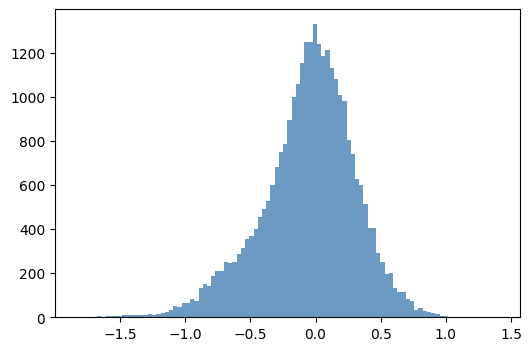

MYC
Max:1.856, Min:-1.649, Median:0.323


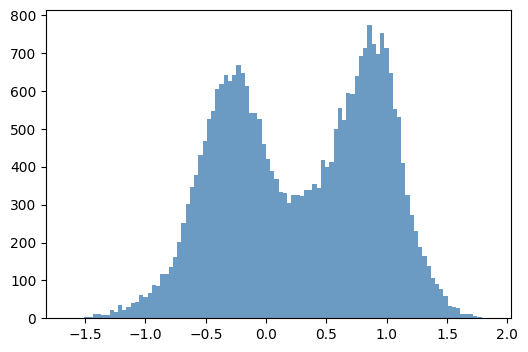

Macrophages
Max:1.500, Min:-1.629, Median:-0.191


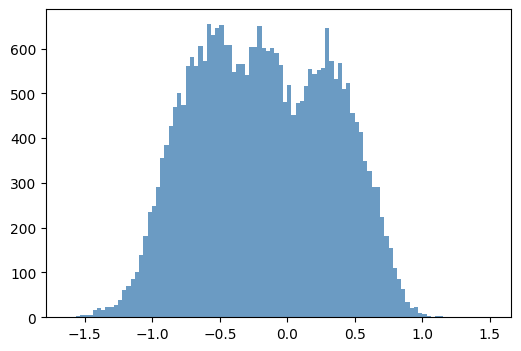

Matrix
Max:1.348, Min:-1.393, Median:-0.199


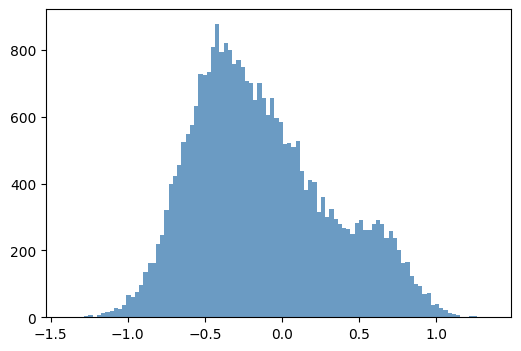

NK-cells
Max:1.336, Min:-1.986, Median:-0.222


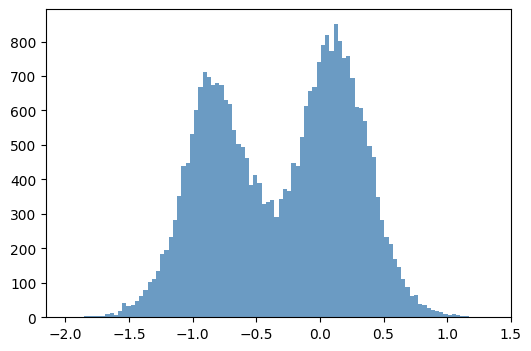

Stress
Max:1.321, Min:-1.767, Median:-0.014


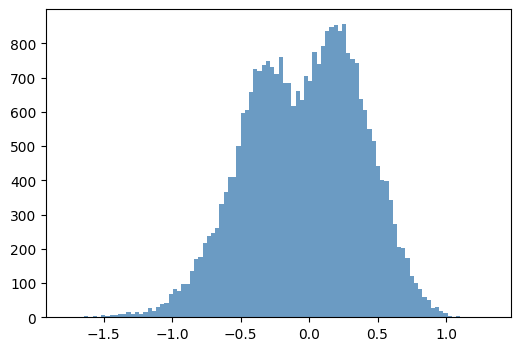

T-cells
Max:1.061, Min:-1.360, Median:-0.261


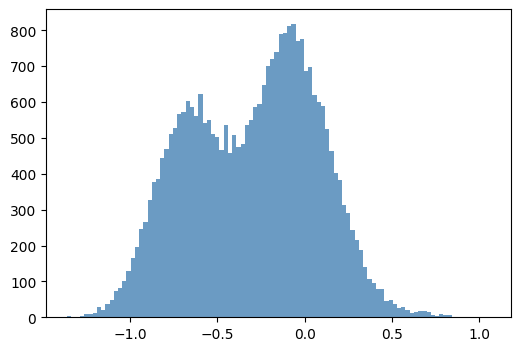

In [ ]:
X = adata.X.toarray()
for idx, p_name in enumerate(adata.var_names):
    print(p_name)
    describe(X[:,idx])

In [ ]:
def analyze_h5ad_stats(adata: ad.AnnData, 
                      gene_name: str = None,
                      threshold: float = 0.5,
                      top_percentiles: List[float] = [5, 10]) -> Dict:
    """
    Analysis for anndata objects
    
    Parameters:
    -----------
    adata : AnnData
        input anndata object
    gene_name : str, optional
        Specify the gene name for analysis. If None, the average expression of all genes will be analyzed.
    threshold : float, default=0.5
        Threshold for positive spot
    top_percentiles : List[float], default=[5, 10]
        Percentage list of hotspot analysis
    
    Returns:
    --------
    Dict
        A dictionary containing all analysis results
    """
    
    if gene_name is not None:
        if gene_name not in adata.var.index:
            raise ValueError(f"Gene '{gene_name}' not exist")
        gene_idx = adata.var.index.get_loc(gene_name)
        expression_data = adata.X[:, gene_idx]
        analysis_target = f"Gene {gene_name}"
    else:
        expression_data = np.mean(adata.X, axis=1)
        analysis_target = "All gene average"
    
    if hasattr(expression_data, 'toarray'):
        expression_data = expression_data.toarray().flatten()
    elif hasattr(expression_data, 'A1'):
        expression_data = expression_data.A1
    else:
        expression_data = np.array(expression_data).flatten()
    
    n_spots = len(expression_data)
    
    mean_score = np.mean(expression_data)
    
    percentiles = {
        'P25': np.percentile(expression_data, 25),
        'P50': np.percentile(expression_data, 50),  
        'P75': np.percentile(expression_data, 75),
        'P90': np.percentile(expression_data, 90)
    }
    
    # Top k% hotspot average
    top_hotspots = {}
    for k in top_percentiles:
        threshold_val = np.percentile(expression_data, 100 - k)
        top_k_spots = expression_data[expression_data >= threshold_val]
        top_hotspots[f'Top_{k}%'] = {
            'threshold': threshold_val,
            'count': len(top_k_spots),
            'mean': np.mean(top_k_spots) if len(top_k_spots) > 0 else 0
        }
    
    total_sum = np.sum(expression_data)
    
    valid_spots = expression_data[expression_data > 0] 
    n_valid_spots = len(valid_spots)
    mean_per_valid_spot = total_sum / n_valid_spots if n_valid_spots > 0 else 0
    
    positive_spots = expression_data[expression_data > threshold]
    positive_ratio = len(positive_spots) / n_spots
    
    std_dev = np.std(expression_data)
    cv = std_dev / mean_score if mean_score != 0 else np.inf  
    
    results = {
        'analysis_target': analysis_target,
        'basic_stats': {
            'total_spots': n_spots,
            'valid_spots': n_valid_spots,
            'mean_score': mean_score,
            'total_sum': total_sum,
            'mean_per_valid_spot': mean_per_valid_spot
        },
        'percentiles': percentiles,
        'top_hotspots': top_hotspots,
        'positive_analysis': {
            'threshold': threshold,
            'positive_spots_count': len(positive_spots),
            'positive_ratio': positive_ratio,
            'positive_percentage': positive_ratio * 100
        },
        'variability': {
            'standard_deviation': std_dev,
            'coefficient_of_variation': cv
        }
    }
    
    return results

In [ ]:
analyze_h5ad_stats(adata)

{'analysis_target': 'All gene average',
 'basic_stats': {'total_spots': 29890,
  'valid_spots': 10865,
  'mean_score': -0.058957994,
  'total_sum': -1762.2544,
  'mean_per_valid_spot': -0.16219552641797055},
 'percentiles': {'P25': -0.18763040751218796,
  'P50': -0.06910670548677444,
  'P75': 0.06077280081808567,
  'P90': 0.16916067600250254},
 'top_hotspots': {'Top_5%': {'threshold': 0.23623082935810086,
   'count': 1495,
   'mean': 0.31438968},
  'Top_10%': {'threshold': 0.16916067600250254,
   'count': 2989,
   'mean': 0.2568678}},
 'positive_analysis': {'threshold': 0.5,
  'positive_spots_count': 33,
  'positive_ratio': 0.0011040481766477082,
  'positive_percentage': 0.11040481766477082},
 'variability': {'standard_deviation': 0.17263316,
  'coefficient_of_variation': -2.9280703}}

#### scanpy analysis

In [ ]:
!pip3 install igraph leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 1.6 MB/s  0:00:03m 1.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 613.8 kB/s  0:00:048.6 kB/s eta 0:00:01:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [leidenalg]━━━━━━━━ 2/3 [leidenalg]


In [ ]:
# sc.pp.scale(adata) # optional
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.4)

/tmp/ipykernel_9311/2656928033.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.4)


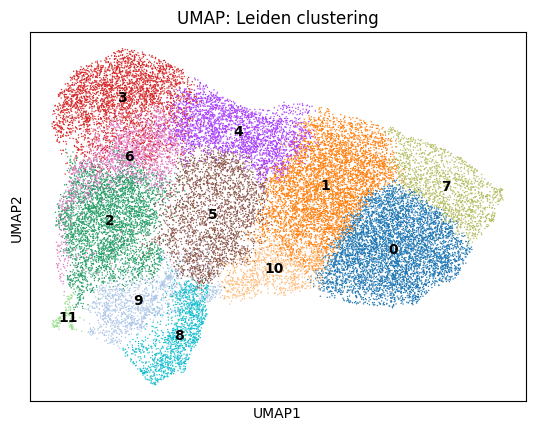

In [ ]:
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=['leiden'],       
    legend_loc='on data',   
    title='UMAP: Leiden clustering'
)

/tmp/ipykernel_9311/1203436655.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


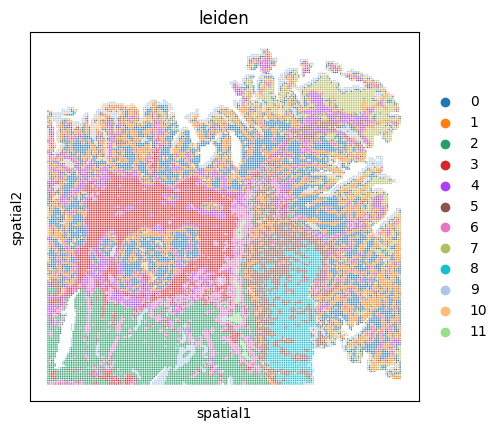

In [ ]:
sc.pl.spatial(
    adata,
    color='leiden',            
    spot_size=100,              
    img_key=None,                
)